In [1]:
import tensorflow as tf
from tensorflow import keras
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.7/dist-packages (0.13.0)


### Loading A_Z Handwritten dataset

In [2]:
#dataset source https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format
az_data = pd.read_csv('./data/AZ_Handwritten_Data.csv').astype('uint8')
az_data.rename(columns={'0':'label'}, inplace=True)

X_az = az_data.drop('label', axis=1).to_numpy()
X_az = X_az.reshape(-1,28,28)
y_az = az_data['label'].to_numpy()

### Loading mnist dataset

In [3]:
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = keras.datasets.mnist.load_data(path="mnist.npz")

X_mnist_full = np.concatenate((X_mnist_train, X_mnist_test))
y_mnist_full = np.concatenate((y_mnist_train, y_mnist_test))

### Visualization

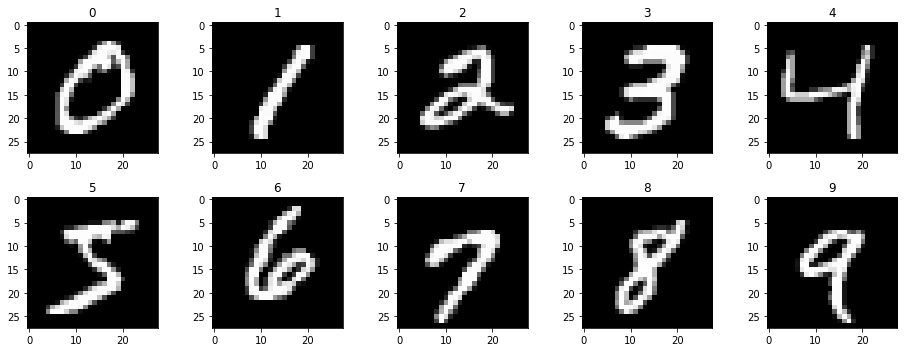

In [4]:
_, index = np.unique(y_mnist_full, return_index=True)
fig, axs = plt.subplots(2, 5, figsize=(13,5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.set_title(y_mnist_full[index[i]])
    ax.imshow(X_mnist_full[index[i]], cmap='gray')

plt.tight_layout()
plt.show()

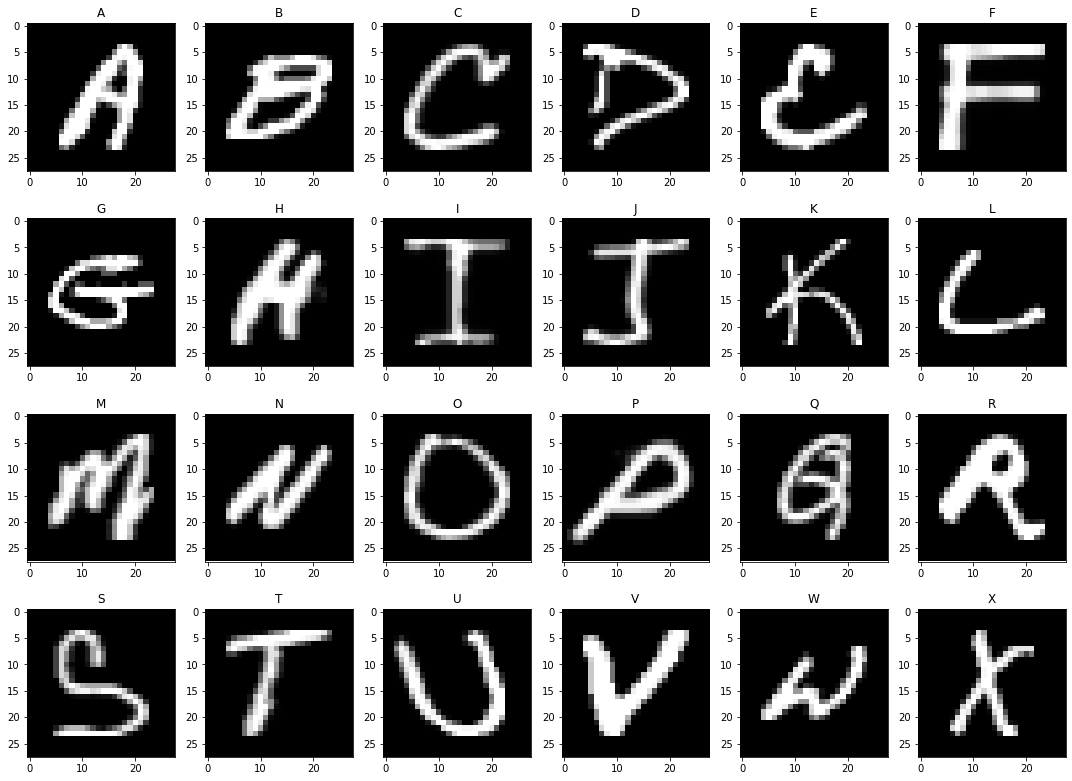

In [5]:
_, index = np.unique(y_az, return_index=True)
fig, axs = plt.subplots(4, 6, figsize=(15,11))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.set_title(string.ascii_uppercase[y_az[index[i]]])
    ax.imshow(X_az[index[i]], cmap='gray')

plt.tight_layout()
plt.show()

### Full handwritten letters + numbers data

y values: 
- 0-9 - numbers 0-9
- 10-35 - letters A-Z

In [6]:
y_az_inc = y_az+10

print(np.unique(y_mnist_full))
print(np.unique(y_az_inc))

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35]


In [7]:
X_full = np.concatenate((X_mnist_full, X_az))
y_full = np.concatenate((y_mnist_full, y_az_inc))

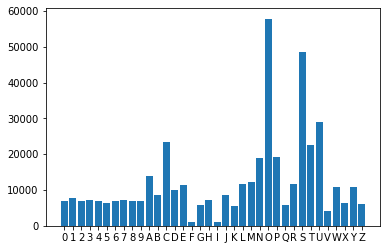

In [8]:
_, frequency_count = np.unique(y_full, return_counts=True)
label = ["%d" %i for i in range(0,10)] + list(string.ascii_uppercase)
plt.bar(label, frequency_count)
plt.show()

### Model training

In [9]:
class CFG():
    AUTO = tf.data.experimental.AUTOTUNE
    labels_len = len(np.unique(y_full))
    random_seed = 42
    image_size = 28
    folds = 5

    batch_size = 32
    lr = 1e-5
    epochs = 100

In [10]:
def preprocess(image, label):
    label = tf.one_hot(label, CFG.labels_len)
    label = tf.cast(label, tf.uint8)

    image = tf.cast(image, tf.float32) / 255.
    image = tf.reshape(image, [-1, CFG.image_size, CFG.image_size, 1])

    return image.numpy(), label.numpy()

X_pp, y_pp = preprocess(X_full, y_full)


In [11]:
def augmentation(image, label):
    # rotation -40 to 40 deg counterclockwise
    k_rad = tf.random.uniform([1], minval=-0.6981, maxval=0.6981, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, k_rad)

    image = tf.clip_by_value(image, 0.0, 1.0)
    image = tf.reshape(image, [CFG.image_size, CFG.image_size, 1])
    return image, label

def get_dataset(X, y, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X,y))
    if shuffle:
        dataset = dataset.shuffle(len(X))
    # dataset = dataset.map(parse_function, num_parallel_calls=AUTO)
    if augment:
        dataset = dataset.map(augmentation, num_parallel_calls=CFG.AUTO)
    dataset = dataset.batch(CFG.batch_size)
    return dataset.prefetch(1)

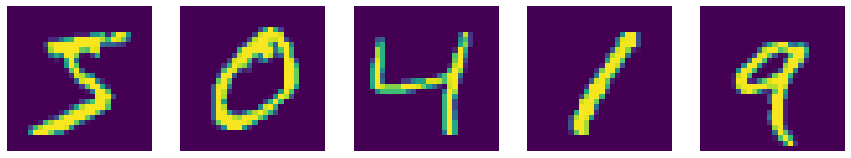

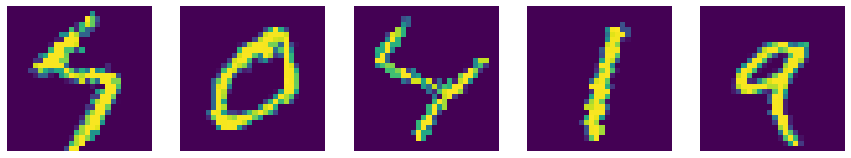

In [12]:
def visualize_5_imgs(dataset):
    plt.figure(figsize=[15, 15])
    for i, sample in enumerate(dataset.unbatch().take(5).as_numpy_iterator()):
        plt.subplot(1, 5, i + 1)
        plt.imshow(sample[0].reshape((CFG.image_size, CFG.image_size)))
        # plt.title(sample[1])
        plt.axis('off')
    plt.show()

ds = get_dataset(X_pp, y_pp)
visualize_5_imgs(ds)
ds_aug = get_dataset(X_pp, y_pp, augment=True)
visualize_5_imgs(ds_aug)

In [13]:
def get_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=(CFG.image_size, CFG.image_size, 1)),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(CFG.labels_len, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [56]:
from sklearn.model_selection import KFold

callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', verbose=1)
]

kfold = KFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.random_seed)
xd = 0
for i, (train_index, val_index) in enumerate(kfold.split(X_pp, y_pp)):
    X_train, y_train = X_pp[train_index], y_pp[train_index]
    X_val, y_val = X_pp[list(val_index)], y_pp[list(val_index)]
    
    ds_train = get_dataset(X_train, y_train, shuffle=True, augment=True)
    ds_val = get_dataset(X_val, y_val)

    model = get_model()
    model.fit(ds_train, validation_data=ds_val, callbacks=callbacks, epochs=CFG.epochs)

In [17]:

# model.fit(ds, epochs=100, callbacks=callbacks)

In [ ]:
# model.evaluate(X_test, y_test)

In [ ]:
# model.save('.//Models//mnist_alphabet')